# Imports

In [5]:
import pyaudio
import wave
import numpy as np
import logging
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq, rfft, irfft

logging.basicConfig(level=logging.INFO)

Could not import the PyAudio C module 'pyaudio._portaudio'.


ImportError: dlopen(/Users/dormouse/Python/Cursor/acoustic_doa/.venv/lib/python3.12/site-packages/pyaudio/_portaudio.cpython-312-darwin.so, 0x0002): symbol not found in flat namespace '_PaMacCore_SetupChannelMap'

In [ ]:
c = 343.0  # Speed of sound in m/s
d = 0.1  # Distance between microphones in meters
fs = 48000  # Sampling frequency in Hz
max_shift = int(d / c * fs) + 1  # Maximum shift in samples
shift_values = np.arange(-max_shift, max_shift + 1)

# Audio

## Record

In [ ]:
chunk_size = 4800
dtype = pyaudio.paInt16
n_channels = 2
rate = 48000
record_seconds = 1
wave_output_filename = "output.wav"

In [ ]:
p = pyaudio.PyAudio()
stream = p.open(format=dtype,
                channels=n_channels,
                rate=rate,
                input=True,
                # input_device_index=2,
                frames_per_buffer=chunk_size)
logging.info("* recording")
frames = []
for i in range(0, int(rate / chunk_size * record_seconds)):
    raw_data = stream.read(chunk_size)
    frames.append(raw_data)
logging.info("* done recording")
stream.stop_stream()
stream.close()
p.terminate()

INFO:root:* recording
INFO:root:* done recording


In [ ]:
full_binary = b''.join(frames)
full_array = np.frombuffer(full_binary, dtype=np.int16)
channel_0 = full_array[0::n_channels]
channel_1 = full_array[1::n_channels]
channels = np.vstack((channel_0, channel_1))#, channel_2, channel_3))
channels.shape

(2, 48000)

## Plot

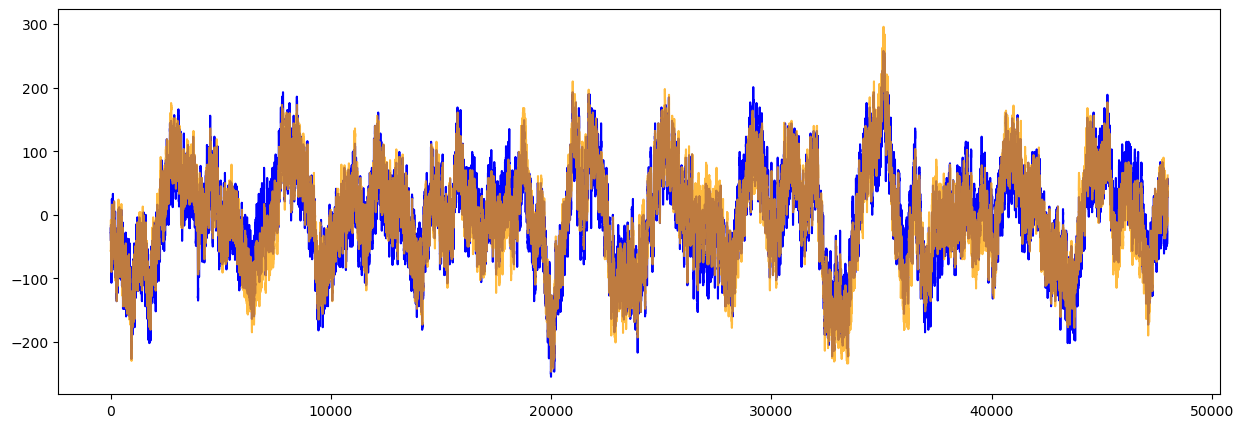

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(channels[0], c='blue')
plt.plot(channels[1], c='orange',alpha=0.75)
# plt.plot(channels[2], c='green')
# plt.plot(channels[3], c='red')
# plt.xlim(14680, 14720)

(0.0, 1200.0)

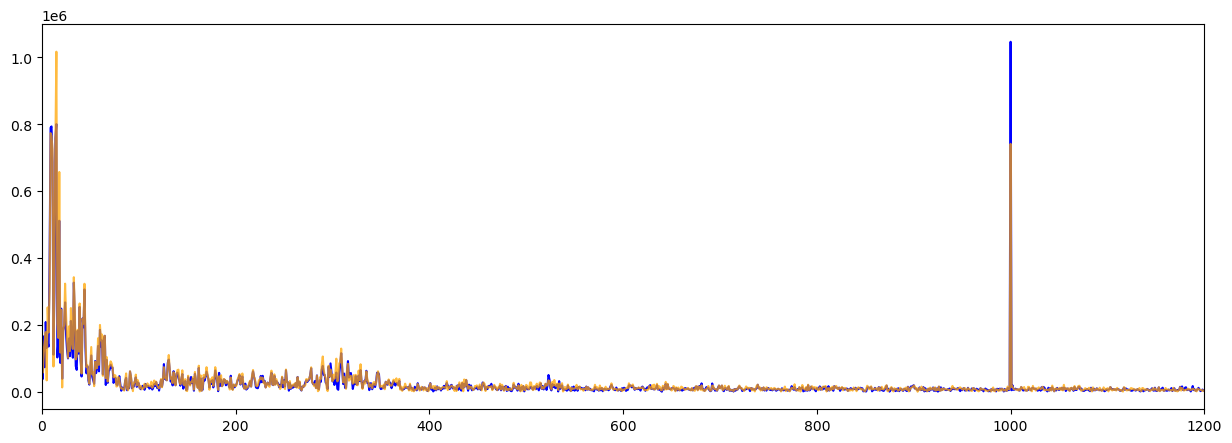

In [ ]:
X = rfft(channels)

plt.figure(figsize=(15,5))
plt.plot(np.abs(X[0]), c='blue')
plt.plot(np.abs(X[1]), c='orange',alpha=0.75)
plt.xlim(0,1200)

(0.0, 1200.0)

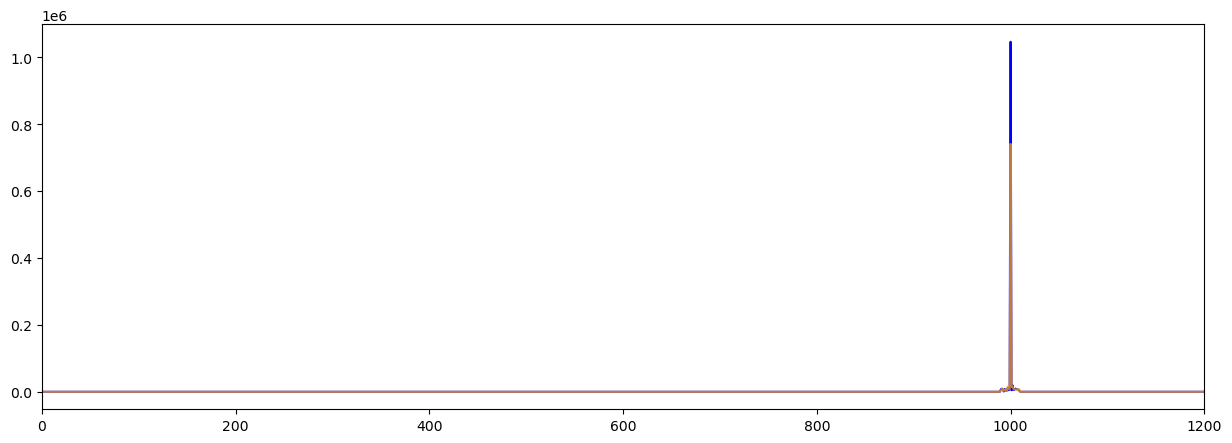

In [ ]:
X[:, :990] = 0
X[:, 1010:] = 0

plt.figure(figsize=(15,5))
plt.plot(np.abs(X[0]), c='blue')
plt.plot(np.abs(X[1]), c='orange',alpha=0.75)
plt.xlim(0,1200)

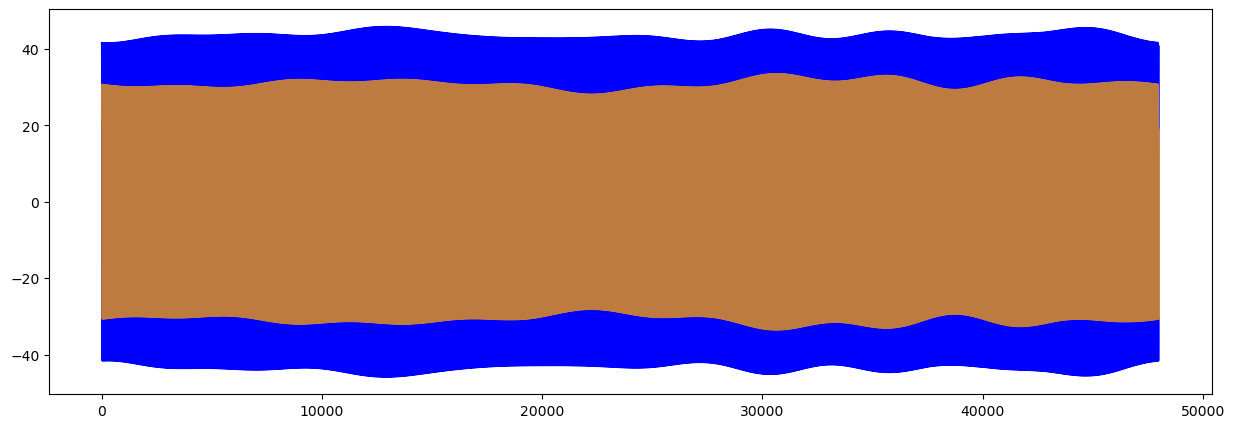

In [ ]:
filtered = irfft(X)

plt.figure(figsize=(15,5))
plt.plot(filtered[0], c='blue')
plt.plot(filtered[1], c='orange', alpha=0.75)

## Compute Shift

In [ ]:
scalar_products = np.array([filtered[0] @ np.roll(filtered[1], shift=i) for i in shift_values])

In [ ]:
max_shift_raw = np.argmax(scalar_products)
max_shift = shift_values[max_shift_raw]

In [ ]:
max_shift

np.int64(-5)

## Save

In [ ]:
# channel = 3
# wf = wave.open(f"output_channel_{channel}.wav", 'wb')
# wf.setnchannels(1)
# wf.setsampwidth(p.get_sample_size(dtype))
# wf.setframerate(rate)
# wf.writeframes(full_binary[channel::n_channels])
# wf.close()

In [ ]:
# channel = 0
# with wave.open("output.wav") as wav:
#     nch   = wav.getnchannels()
#     depth = wav.getsampwidth()
#     wav.setpos(0)
#     sdata = wav.readframes(wav.getnframes())

#     # Extract channel data (24-bit data not supported)
#     typ = { 1: np.uint8, 2: np.uint16, 4: np.uint32 }.get(depth)
#     if not typ:
#         raise ValueError("sample width {} not supported".format(depth))
#     print ("Extracting channel {} out of {} channels, {}-bit depth".format(channel+1, nch, depth*8))
#     data = np.fromstring(sdata, dtype=typ)
#     print(data.shape)
#     ch_data = data[channel::nch]
#     print(ch_data.shape)

#     # # Save channel to a separate file
#     # outwav = wave.open(filename, 'w')
#     # outwav.setparams(wav.getparams())
#     # outwav.setnchannels(1)
#     # outwav.writeframes(ch_data.tostring())
#     # outwav.close()

Extracting channel 1 out of 4 channels, 16-bit depth
(880640,)
(220160,)


C:\Users\arsen\AppData\Local\Temp\ipykernel_8376\2678907393.py:13: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(sdata, dtype=typ)


# Orchestrate

In [ ]:
rate = 48000
computations_frequency = 1  # per second
chunk_size = int(rate/computations_frequency)
dtype = pyaudio.paInt16
n_channels = 4
record_seconds = 100
target_frequency = 1000

In [ ]:
p = pyaudio.PyAudio()
stream = p.open(format=dtype,
                channels=n_channels,
                rate=rate,
                input=True,
                # input_device_index=2,
                frames_per_buffer=chunk_size)
logging.info("* recording")

frames = []
for i in range(0, int(rate / chunk_size * record_seconds)):
    raw_data = stream.read(chunk_size)
    # frames.append(raw_data)
    data = np.frombuffer(raw_data, dtype=np.int16)
    channel_0 = data[0::n_channels]
    channel_1 = data[2::n_channels]
    channels = np.vstack((channel_0, channel_1))#, channel_2, channel_3))

    X = rfft(channels)
    X[:, :int(target_frequency*0.9)] = 0
    X[:, int(target_frequency*1.1):] = 0
    filtered_data = irfft(X)

    scalar_products = np.array([filtered_data[0] @ np.roll(filtered_data[1], shift=i) for i in shift_values])
    max_shift_raw = np.argmax(scalar_products)
    max_shift = shift_values[max_shift_raw]
    logging.info(max_shift)

logging.info("* done recording")
stream.stop_stream()
stream.close()
p.terminate()

INFO:root:* recording
INFO:root:4
INFO:root:-1
INFO:root:-3
INFO:root:-2
INFO:root:-3
INFO:root:-3
INFO:root:-3
INFO:root:-4
INFO:root:-8
INFO:root:-14
INFO:root:-14
INFO:root:-14
INFO:root:-14
INFO:root:-14
INFO:root:-14
INFO:root:-8
INFO:root:-5
INFO:root:-4
INFO:root:-1
INFO:root:1
INFO:root:3
INFO:root:4
INFO:root:6
INFO:root:9
INFO:root:14
INFO:root:14
INFO:root:14
INFO:root:14
INFO:root:12
INFO:root:4
INFO:root:-1
INFO:root:-1
INFO:root:0
INFO:root:-6
INFO:root:-9
INFO:root:-10
INFO:root:-10
INFO:root:-9
INFO:root:-9
INFO:root:-7
INFO:root:-10
INFO:root:-9
INFO:root:-7
INFO:root:3
INFO:root:9
INFO:root:11
INFO:root:6


KeyboardInterrupt: 